In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import umap
from matplotlib import pyplot as plt

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

import con_score

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
df = pd.read_csv("../output/Survivor/final_vote_history.csv")
castaways = pd.read_csv("../output/Survivor/final_castaways.csv")

In [3]:
le1 = LabelEncoder()
le1.fit(df['castaway_uid'].unique().tolist() + df['vote_uid'].unique().tolist())
df['castaway_encoded'] = le1.transform(df['castaway_uid'])
df['vote_encoded'] = le1.transform(df['vote_uid'])

In [4]:
# max_epi = 8
#df = df[df.episode <= max_epi]

In [5]:
df.castaway_uid.nunique()

741

Merge final episodes

In [6]:
df_grouped = df.copy()
df_grouped['episode'] = df_grouped['episode'].apply(lambda x: x if x <= 12 else 12)

In [7]:
df_grouped.shape

(4239, 28)

In [8]:
df_grouped.castaway_uid.nunique()   

741

### CON Score

In [9]:
con_scores_df = con_score.calculate_CON_multiorder1(df_grouped)

In [10]:
con_scores_df_1st = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'1st_order_CON_score': 'sum'}).reset_index()
con_scores_df_2nd = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'2nd_order_CON_score': 'sum'}).reset_index()
con_scores_df_lrg = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'full_CON_score': 'sum'}).reset_index()
con_scores_df_pr = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'pagerank': 'sum'}).reset_index()
con_scores_df_cn = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'closeness': 'sum'}).reset_index()
con_scores_df_id = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'in_degree': 'sum'}).reset_index()
con_scores_df_od = con_scores_df.groupby(['castaway_uid', 'episode']).agg({'out_degree': 'sum'}).reset_index()

In [11]:
con_matrix_1st = con_scores_df_1st.pivot(index='castaway_uid', columns='episode', values='1st_order_CON_score')
con_matrix_1st.columns = [f"1storder_{col}" for col in con_matrix_1st.columns]
con_matrix_1st = con_matrix_1st.fillna(0)

con_matrix_2nd = con_scores_df_2nd.pivot(index='castaway_uid', columns='episode', values='2nd_order_CON_score')
con_matrix_2nd.columns = [f"2ndorder_{col}" for col in con_matrix_2nd.columns]
con_matrix_2nd = con_matrix_2nd.fillna(0)

con_matrix_lrg = con_scores_df_lrg.pivot(index='castaway_uid', columns='episode', values='full_CON_score')
con_matrix_lrg.columns = [f"CON_{col}" for col in con_matrix_lrg.columns]
con_matrix_lrg = con_matrix_lrg.fillna(0)

con_matrix_pr = con_scores_df_pr.pivot(index='castaway_uid', columns='episode', values='pagerank')
con_matrix_pr.columns = [f"pagerank_{col}" for col in con_matrix_pr.columns]
con_matrix_pr = con_matrix_pr.fillna(0)

con_matrix_cn = con_scores_df_cn.pivot(index='castaway_uid', columns='episode', values='closeness')
con_matrix_cn.columns = [f"closeness_{col}" for col in con_matrix_cn.columns]
con_matrix_cn = con_matrix_cn.fillna(0)

con_matrix_id = con_scores_df_id.pivot(index='castaway_uid', columns='episode', values='in_degree')
con_matrix_id.columns = [f"indegree_{col}" for col in con_matrix_id.columns]
con_matrix_id = con_matrix_id.fillna(0)

con_matrix_od = con_scores_df_od.pivot(index='castaway_uid', columns='episode', values='out_degree')
con_matrix_od.columns = [f"outdegree_{col}" for col in con_matrix_od.columns]
con_matrix_od = con_matrix_od.fillna(0)

In [12]:
con_matrix_2nd = con_matrix_2nd.reindex(con_matrix_1st.index)
con_matrix_lrg = con_matrix_lrg.reindex(con_matrix_1st.index)
con_matrix_pr = con_matrix_pr.reindex(con_matrix_1st.index)
con_matrix_cn = con_matrix_cn.reindex(con_matrix_1st.index)
con_matrix_od = con_matrix_od.reindex(con_matrix_1st.index)
con_matrix_id = con_matrix_id.reindex(con_matrix_1st.index)

In [13]:
combined_matrix = pd.concat([#con_matrix_1st, 
                             #con_matrix_2nd, 
                             con_matrix_lrg, 
                             con_matrix_pr, con_matrix_cn, con_matrix_od, con_matrix_id], axis=1)
matrix_df_combined = combined_matrix.reset_index()

In [14]:
matrix_df_combined

,castaway_uid,CON_1.0,CON_2.0,CON_3.0,CON_4.0,CON_5.0,CON_6.0,CON_7.0,CON_8.0,CON_9.0,...,indegree_3.0,indegree_4.0,indegree_5.0,indegree_6.0,indegree_7.0,indegree_8.0,indegree_9.0,indegree_10.0,indegree_11.0,indegree_12.0
0,1.0B.B.,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0Colleen,0.0,14.0,0.0,11.0,0.0,10.0,7.0,16.0,13.0,...,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0
2,1.0Dirk,13.0,0.0,12.0,0.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0Gervase,0.0,14.0,0.0,11.0,0.0,10.0,7.0,16.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0
4,1.0Greg,0.0,14.0,0.0,6.0,0.0,10.0,1.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,9.0Lisa,0.0,14.0,12.0,0.0,10.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
755,9.0Mia,0.0,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
756,9.0Rory,15.0,0.0,14.0,12.0,10.0,8.0,0.0,16.0,0.0,...,3.0,1.0,1.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0
757,9.0Travis,15.0,0.0,14.0,12.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
X = matrix_df_combined.iloc[:, 1:].to_numpy()

In [16]:
X.shape

(759, 60)

In [17]:
with open("../output/Survivor/Survivor_con_matrix_np.pkl", "wb") as f:
    pickle.dump(X, f)

Create true labels

In [18]:
castaway_dict = castaways.set_index('castaway_uid').to_dict()['result']
castaway_results = [castaway_dict[castaway] for castaway in matrix_df_combined['castaway_uid']]
results_df = pd.DataFrame({'result': castaway_results})
results_df['result_quantile'] = pd.qcut(results_df['result'].rank(method='first'), q=[0, 0.2, 0.8, 1], labels=False)
y = np.array(results_df['result_quantile'].astype(int))

In [19]:
np.bincount(y)

array([152, 455, 152], dtype=int64)

In [20]:
result_quantile_counts = results_df.value_counts('result_quantile')
print(result_quantile_counts)

result_quantile
1    455
0    152
2    152
Name: count, dtype: int64


Split data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [22]:
np.bincount(y_train)

array([108, 327,  96], dtype=int64)

SMOTE

In [23]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Train models

In [24]:
models = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "SupportVectorClassifier-LINEAR": SVC(random_state=42, kernel='linear'),
    "XGBClassifier": xgb.XGBClassifier(random_state=42),
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

predictions, saved_models = [], {}
for name, model in tqdm(models.items()):
    model.fit(X_train_smote, y_train_smote)
    saved_models[name] = model
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)

100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


In [25]:
np.bincount(predictions[0])

array([ 44, 143,  41], dtype=int64)

In [26]:
results = pd.DataFrame(results)
display(results.sort_values('Accuracy', ascending=False))
results.to_csv("../output/Survivor/Survivor_CON_score_ML_results.csv")

,Model,Accuracy,Precision,Recall,F1-Score
3,SupportVectorClassifier-LINEAR,0.815789,0.779886,0.807224,0.787963
2,RandomForestClassifier,0.750000,0.704537,0.696631,0.700045
4,XGBClassifier,0.750000,0.712780,0.694907,0.701547
0,GradientBoostingClassifier,0.728070,0.684576,0.658550,0.666338
1,DecisionTreeClassifier,0.662281,0.607456,0.566322,0.578154


### UMAP Visualization

In [27]:
results_df['result_quantile1'] = pd.qcut(results_df['result'].rank(method='first'), q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=[0,1,2,3,4])
y1 = np.array(results_df['result_quantile1'].astype(int))
color_map1 = {0: 'brown', 1: 'orange', 2: 'red', 3: 'green', 4: 'purple'}
np.bincount(y1)

array([152, 152, 151, 152, 152], dtype=int64)

In [28]:
results_df['result_quantile1'].value_counts()

result_quantile1
0    152
1    152
3    152
4    152
2    151
Name: count, dtype: int64

In [29]:
umap_reducer = umap.UMAP(n_components=2, random_state=42, 
                         n_neighbors=75, 
                         spread=15, 
                         min_dist=0.5,
                         metric='euclidean'
                         )
embedding = umap_reducer.fit_transform(X, y=y1)

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


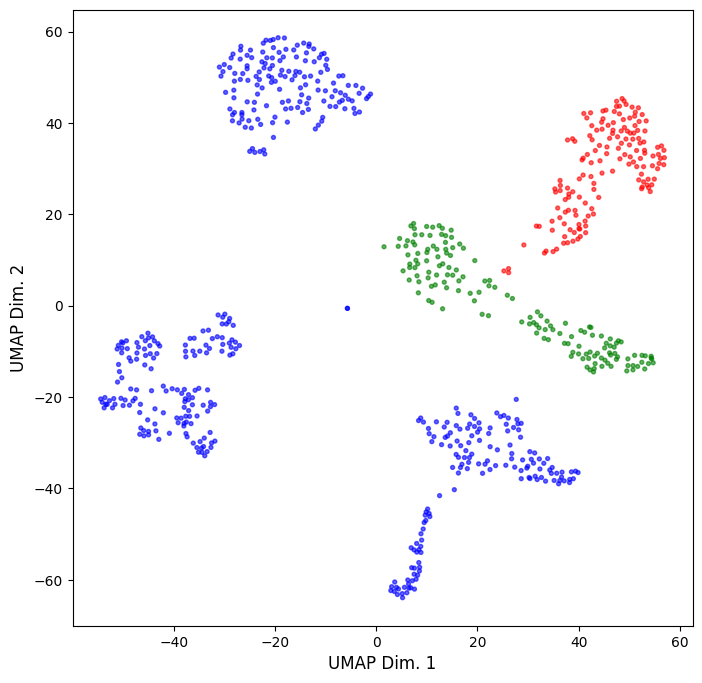

In [30]:
plt.figure(figsize=(8, 8))
color_map = {0: 'red', 1: 'blue', 2: 'green'}
colors = [color_map[label] for label in y]
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors,  s=8, alpha=0.6)
plt.xlabel("UMAP Dim. 1", fontsize=12)
plt.ylabel("UMAP Dim. 2", fontsize=12)
plt.savefig("../output/Survivor/Survivor_CON_UMAP.eps", format='eps')
plt.show()

In [31]:
full_results_dict = {castaway: castaway_dict[castaway] for castaway in matrix_df_combined['castaway_uid']}

In [32]:
with open("../output/Survivor/Survivor_outcome_dict.pkl", "wb") as f:
    pickle.dump(full_results_dict, f)

#### Feature Importance

In [33]:
model = models['XGBClassifier']
feature_names = matrix_df_combined.iloc[:, 1:].columns
feature_importance = pd.DataFrame({'Feature': feature_names,  'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

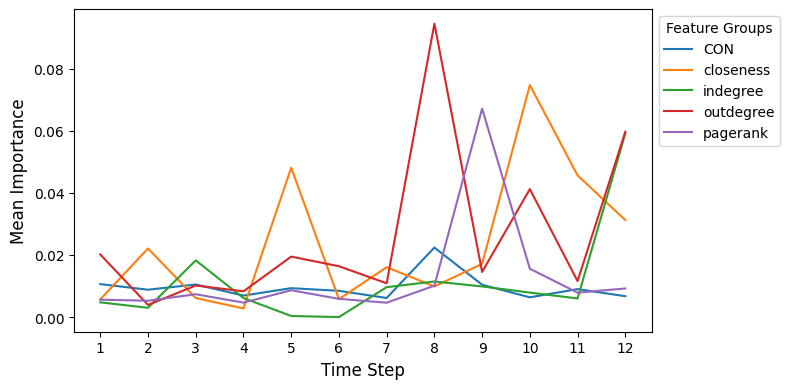

In [34]:
feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
feature_importance['Time_Step'] = feature_importance['Feature'].str.split('_').str[1]

group_time_mean_importance = feature_importance.groupby(['Feature_Group', 'Time_Step'], as_index=False)['Importance'].mean()

time_step_importance = group_time_mean_importance.pivot(index='Time_Step', columns='Feature_Group', values='Importance')
time_step_importance.index = time_step_importance.index.astype(float).astype(int)
time_step_importance = time_step_importance.sort_index(ascending=True)

plt.figure(figsize=(8, 4))
for group in time_step_importance.columns:
    plt.plot(time_step_importance.index, time_step_importance[group], label=group)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Mean Importance', fontsize=12)
plt.xticks(ticks=range(1, 13))  
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Feature Groups")
plt.grid(False)
plt.tight_layout()
plt.savefig("../output/Survivor/Survivor_fi_time_plot.svg", format='svg')
plt.show()

In [35]:
max_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].max()
max_importance = max_importance.sort_values(by='Importance', ascending=False)
display(max_importance)

,Feature_Group,Importance
3,outdegree,0.094522
1,closeness,0.074742
4,pagerank,0.067148
2,indegree,0.059167
0,CON,0.022395


,Feature_Group,Importance
3,outdegree,0.310794
1,closeness,0.285285
4,pagerank,0.151874
2,indegree,0.136436
0,CON,0.115612


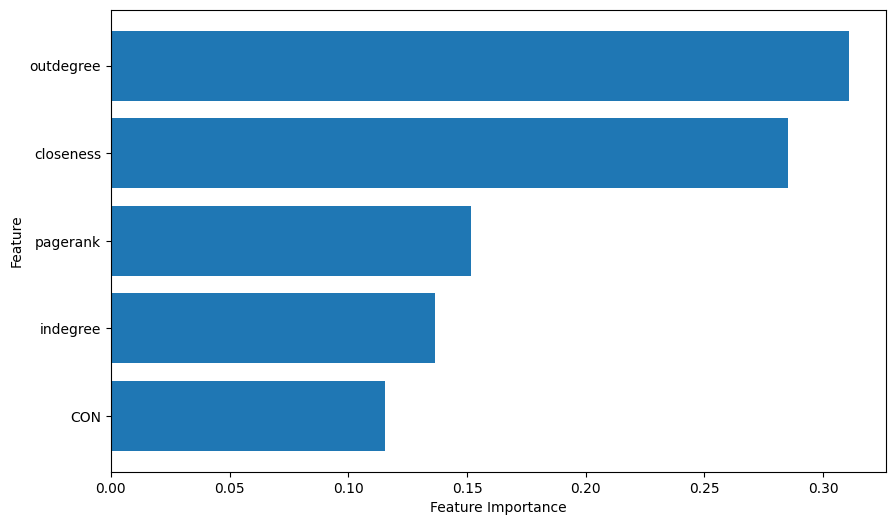

In [36]:
feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
aggregated_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].sum()
aggregated_importance = aggregated_importance.sort_values(by='Importance', ascending=False)
display(aggregated_importance)
plt.figure(figsize=(10, 6))
plt.barh(aggregated_importance['Feature_Group'], aggregated_importance['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  
plt.savefig("../output/Survivor/Survivor_fi_bar_plot.svg", format='svg')
plt.show()

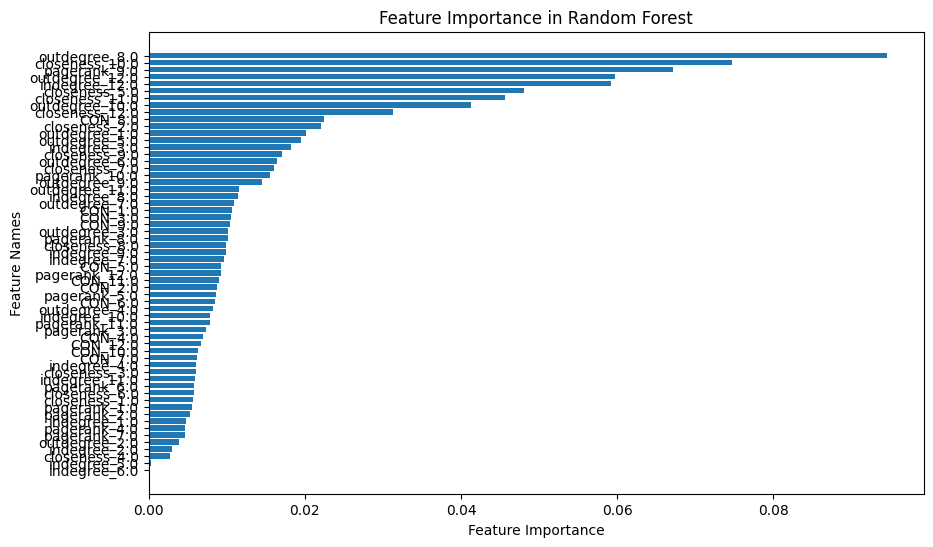

In [37]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  
plt.show()